## Imports

In [ ]:
import pandas as pd

import jax.numpy as jnp
from jax import random, vmap

!pip3 install numpyro
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

!pip3 install arviz
import arviz as az
import matplotlib.pyplot as plt

     |████████████████████████████████| 264 kB 5.0 MB/s 


/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


## 4.1

Here uniform is chosen instead off the binomial bcoz the author assumes each step may not be perfect 1 yard. so it can be b/w 0 - 1 yard (left or right). Thus uniform distribution (1, -1)

In [ ]:
dunif = dist.Uniform(-1, 1)
key = random.PRNGKey(0)
samples = dunif.sample(key, (1000, 16))
pos = jnp.sum(samples, -1)

## 4.2

In [ ]:
dunif = dist.Uniform(0, 0.1)
growthsamples = jnp.prod(1 + dunif.sample(key, (10000, 12)), -1)
growthsamples.shape

(10000,)

## 4.3

Log probability bcoz probly its faster. End result is just the probability of each data point assuming they are sampled from a normal dist

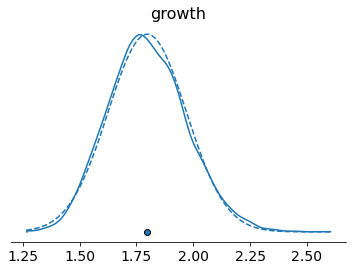

In [ ]:
az.plot_density({'growth': growthsamples}, hdi_prob=1)
x = jnp.sort(growthsamples)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

## 4.4

In [ ]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(key, (10000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(key, (10000, 12)), -1)
big, small

(DeviceArray([18.742033 , 11.604453 , 19.078642 , ...,  7.5537906,
              11.295802 , 23.21978  ], dtype=float32),
 DeviceArray([1.0708382, 1.0577757, 1.0716889, ..., 1.0464755, 1.0573572,
              1.076675 ], dtype=float32))

## 4.5

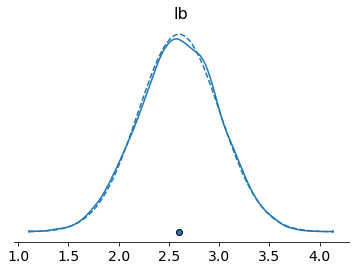

In [ ]:
logbig = jnp.log(big)
az.plot_density({'lb': logbig}, hdi_prob=1)
x = jnp.sort(logbig)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

## 4.6

In [ ]:
w, n = 6, 9
pgrid = jnp.linspace(0, 1, 100)
probbin = jnp.exp(dist.Binomial(n, pgrid).log_prob(w))
post = probbin * jnp.exp(dist.Uniform(0, 1).log_prob(pgrid))
post = post / jnp.sum(post)

## 4.7 - 4.11

In [ ]:
d = pd.read_csv('https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Howell1.csv', delimiter=';')
print(d.info())
d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB
None


,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [ ]:
d2 = d[d.age >= 18]
d2

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0


## 4.12

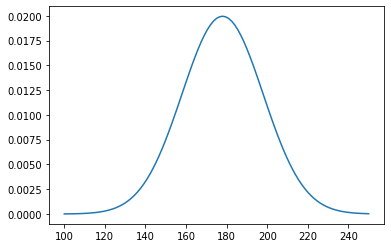

In [ ]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()

## 4.13

/usr/local/lib/python3.7/dist-packages/numpyro/distributions/distribution.py:293: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  "Out-of-support values provided to log prob method. "


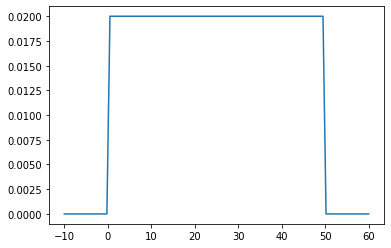

In [ ]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))
plt.show()

## 4.14

In [ ]:
samplemu = dist.Normal(178, 20).sample(key, (10000,))
priorh = dist.Normal(samplemu, samplestd)
priorh.sample(key).shape

## 4.15

In [ ]:
sample_mu = dist.Normal(178, 100).sample(random.PRNGKey(0), (int(1e4),))
samplestd = dist.Uniform(0, 50).sample(random.PRNGKey(1), (10000,))
prior_h = dist.Normal(sample_mu, samplestd).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

## 4.16

Meshgrid returns 2 vars. Now if u iterate thru them, ull get coordinate like results (if not razed, then batch like).

If you use
the obvious approach, like exp(post\$prod ), you’ll get a vector full of zeros, which isn’t very helpful. This
is a result of R’s rounding very small probabilities to zero. Remember, in large samples, all unique samples are
unlikely. This is why you have to work with log-probability. The code in the box dodges this problem by scaling
all of the log-products by the maximum log-product. As a result, the values in post$prob are not all zero, but
they also aren’t exactly probabilities. Instead they are relative posterior probabilities. But that’s good enough for
what we wish to do with these values.

In [ ]:
mulist = jnp.linspace(150, 160, 100)
siglist = jnp.linspace(7, 9, 100)
mesh = jnp.meshgrid(mulist, siglist)
post = {'mu': mesh[0].reshape(-1), 'std': mesh[1].reshape(-1)}
post['LL'] = vmap(lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values)))(post['mu'], post['std'])
lmu = dist.Normal(178, 20).log_prob(post['mu'])
lstd = dist.Uniform(0, 50).log_prob(post['std'])
post['prob'] = post['LL'] + lmu + lstd
post['prob'] = jnp.exp(post['prob'] - jnp.max(post['prob']))
post['prob']

DeviceArray([1.9627382e-35, 5.3549957e-34, 1.3573383e-32, ...,
             2.4945987e-29, 2.4997128e-30, 2.3956824e-31], dtype=float32)

## 4.17 - 4.18

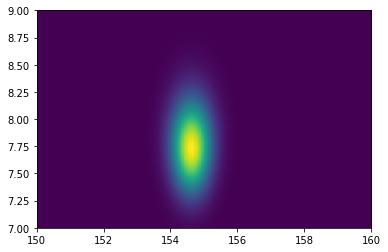

In [ ]:
plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

## 4.19

Dist Categorical is like sampling with replacement ... til n

In [ ]:
prob = post['prob'] / jnp.sum(post['prob'])
samplerows = dist.Categorical(probs=prob).sample(key, (10000,))
smu = post['mu'][samplerows]
sstd = post['std'][samplerows]
sstd

DeviceArray([8.191919, 7.828283, 7.181818, ..., 7.787879, 8.191919,
             7.969697], dtype=float32)

## 4.20

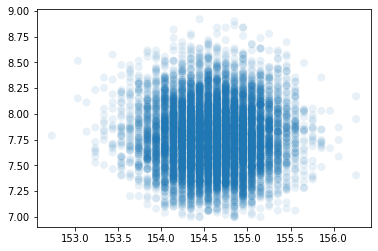

In [ ]:
plt.scatter(smu, sstd, s=64, alpha=0.1, edgecolor="none")
plt.show()

## 4.21 - 4.22

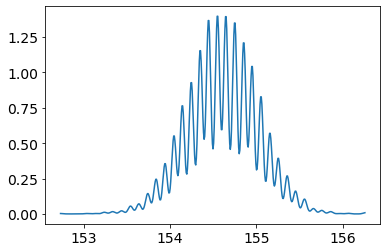

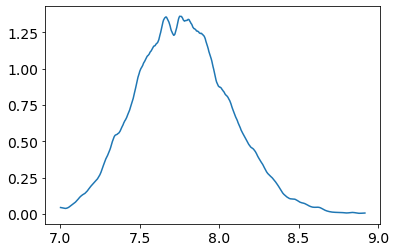

[153.93939 155.15152]
[7.3030305 8.232323 ]


In [ ]:
az.plot_kde(smu)
plt.show()
az.plot_kde(sstd)
plt.show()
print(hpdi(smu, 0.89))
print(hpdi(sstd, 0.89))

## 4.23 - 4.25

Right tail longer for std bcoz it can never be negative (its only one of the reason tho)

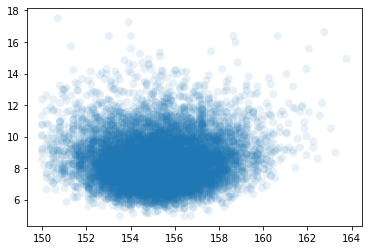

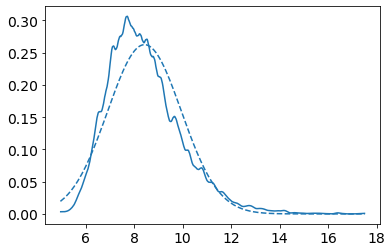

In [ ]:
d3 = d2.height.sample(20)
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

## 4.26 - 4.29

flist is the model

it seems the m4_1 is the quap approx or guide

RN treat it as blackbox

In [ ]:
def flist(height=None):
    mu = numpyro.sample("mu", dist.Normal(178, 20), rng_key=key)
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50), rng_key=key)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

In [ ]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|██████████| 2000/2000 [00:01<00:00, 1682.46it/s, init loss: 4000.1155, avg. loss [1901-2000]: 1226.0389]


In [ ]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.06      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



## 4.30

In [ ]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_loc_fn=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|██████████| 2000/2000 [00:01<00:00, 1887.14it/s, init loss: 1226.0386, avg. loss [1901-2000]: 1226.0389]


## 4.31

In [ ]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_2 = svi_result.params
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)

100%|██████████| 2000/2000 [00:01<00:00, 1853.09it/s, init loss: 1584193.6250, avg. loss [1901-2000]: 1626.5828]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



## 4.32 

In [ ]:
SP = m4_1.sample_posterior(key, p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(SP.values()), axis=0))
vcov

DeviceArray([[0.16016926, 0.00614256],
             [0.00614256, 0.08983827]], dtype=float32)

## 4.33

In [ ]:
var = jnp.diag(vcov)
corr = vcov / jnp.sqrt(jnp.outer(var, var))
print(var)
print(corr)

[0.16016926 0.08983827]
[[1.         0.05120694]
 [0.05120694 1.        ]]


## 4.34 - 4.35

In [ ]:
post = m4_1.sample_posterior(key, p4_1, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    153.92    155.20   1057.91      1.00
     sigma      7.74      0.30      7.72      7.22      8.16    999.28      1.00



## 4.36

In [ ]:
flat = jnp.stack(list(post.values()))
print(flat.shape)
mu, sigma = jnp.mean(flat, axis=1), jnp.cov(flat)
print(mu)
print(sigma)
PD = dist.MultivariateNormal(mu, sigma).sample(key, (1000,))
PD

(2, 1000)
[154.60214    7.740142]
[[0.16016926 0.00614256]
 [0.00614256 0.08983827]]


DeviceArray([[154.71288  ,   7.6871147],
             [154.0322   ,   7.7874837],
             [153.72934  ,   7.9082403],
             ...,
             [154.74446  ,   7.9868274],
             [154.8156   ,   7.1660943],
             [155.00096  ,   8.097288 ]], dtype=float32)

## 4.37

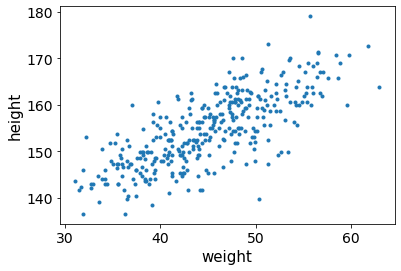

In [ ]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
plt.show()

## 4.38

expand is like setting up individual sample size
and numpyro sample returns a single sample

In [ ]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([N]))
b

DeviceArray([-10.739804  ,  15.258152  ,   9.390772  ,  10.990513  ,
              -5.742629  ,  -1.6551685 ,  11.748211  ,  -3.5540724 ,
              11.745233  ,  15.496597  ,  22.591537  ,   1.9654583 ,
              -7.181623  ,  -6.127078  ,  16.818005  , -10.101911  ,
               6.1073265 , -20.945366  ,   1.4283469 ,   4.4738283 ,
             -21.249674  ,  -1.4819148 ,   2.9982882 ,  -0.45680538,
               4.839028  ,   8.973134  ,  -7.549265  ,  10.098781  ,
              -7.6561904 ,   6.336486  ,  -9.084328  ,  -5.399276  ,
              -8.685374  ,   4.3814025 , -12.5880375 ,   3.8613355 ,
             -13.334694  ,  -6.329398  ,   6.647952  ,   2.8751302 ,
               6.821006  ,  -9.418579  ,  -3.6871285 ,   2.7047493 ,
             -11.225164  , -14.211016  ,   9.475936  ,  -5.425339  ,
               4.864907  ,  -5.8821874 ,  -2.3900967 ,   7.950785  ,
             -18.804157  , -14.908366  ,  -8.651617  ,  -1.9540658 ,
              -9.866924  ,  -8.193

## 4.39

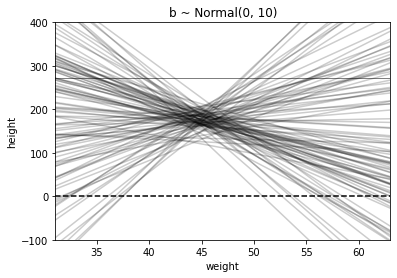

In [ ]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel='weight',
    ylabel='height'
)

plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)

for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

## 4.40

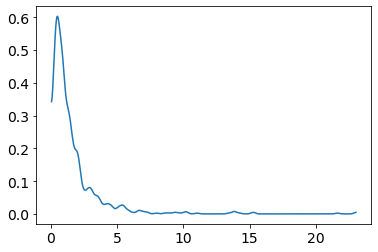

In [ ]:
b = dist.LogNormal(0, 1).sample(key, (1000,))
az.plot_kde(b)
plt.show()

## 4.41

In [ ]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.LogNormal(0, 1).expand([N]))

## 4.42

In [ ]:
 xbar = d2.weight.mean()
 def model(weight, height):
     a = numpyro.sample('a', dist.Normal(178, 20))
     b = numpyro.sample('b', dist.LogNormal(0, 1))
     sigma = numpyro.sample('sigma', dist.Uniform(0, 50))
     mu = numpyro.deterministic('mu', a + b * (weight - xbar))
     numpyro.sample('height', dist.Normal(mu, sigma), obs=height)

m4_3 = AutoLaplaceApproximation(model)

svi = SVI(model, m4_3, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values)
p4_3 = svi.run(key, 2000).params

100%|██████████| 2000/2000 [00:01<00:00, 1510.23it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9297]


## 4.43

In [ ]:
def model(weight, height):
    a = numpyro.sample('a', dist.Normal(178, 20))
    log_b = numpyro.sample('log_b', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.Uniform(0, 50))
    mu = numpyro.deterministic('mu', a + jnp.exp(log_b) * (weight - xbar))
    numpyro.sample('height', dist.Normal(mu, sigma), obs=height)

m4_3b = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3b, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values)
p4_3b = svi.run(key, 2000).params

100%|██████████| 2000/2000 [00:01<00:00, 1415.72it/s, init loss: 40631.5430, avg. loss [1901-2000]: 1078.9297]


## 4.44

In [ ]:
samples = m4_3.sample_posterior(key, p4_3, (1000,))
samples.pop('mu')
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.60      0.28    154.60    154.19    155.05   1143.46      1.00
         b      0.91      0.04      0.91      0.83      0.96   1002.49      1.00
     sigma      5.06      0.19      5.06      4.75      5.37    990.79      1.00



## 4.45

In [ ]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 3)

DeviceArray([[0.07600001, 0.        , 0.001     ],
             [0.        , 0.002     , 0.        ],
             [0.001     , 0.        , 0.038     ]], dtype=float32)

## 4.46

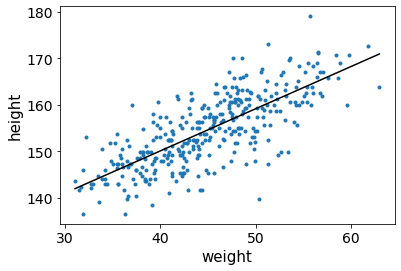

In [ ]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
post = m4_3.sample_posterior(key, p4_3, (1000,))
amap, bmap = jnp.mean(post['a']), jnp.mean(post['b'])
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, amap + bmap * (x - xbar), 'k')
plt.show()

## 4.47

In [ ]:
{k:v[:5] for k, v in post.items()}

{'a': DeviceArray([154.18292, 154.15659, 154.94792, 154.54199, 154.74652], dtype=float32),
 'b': DeviceArray([0.8781922 , 0.84048307, 0.9355199 , 0.8878402 , 0.8960136 ],            dtype=float32),
 'mu': DeviceArray([[156.6727 , 146.71417, 142.65608, ..., 160.48184, 162.14989,
               160.8055 ],
              [156.53946, 147.00854, 143.1247 , ..., 160.18503, 161.78146,
               160.49478],
              [157.60023, 146.99162, 142.66862, ..., 161.65802, 163.43497,
               162.0028 ],
              [157.05913, 146.9912 , 142.88852, ..., 160.91011, 162.59648,
               161.23732],
              [157.28683, 147.1262 , 142.98576, ..., 161.17326, 162.87517,
               161.50348]], dtype=float32),
 'sigma': DeviceArray([5.030914 , 5.3896537, 4.8370104, 5.1705327, 5.1266603], dtype=float32)}

## 4.48

In [ ]:
d10 = d2[:10]

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 50))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - jnp.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m10 = AutoLaplaceApproximation(model)

svi = SVI(model, m10, optim.Adam(1), Trace_ELBO(), weight=d10.weight.values, height=d10.height.values)
p10 = svi.run(key, 1000).params


100%|██████████| 1000/1000 [00:01<00:00, 957.91it/s, init loss: 1235.8605, avg. loss [951-1000]: 40.9584]


## 4.49

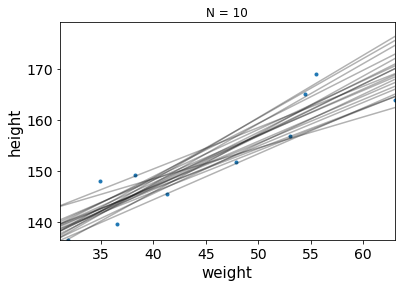

In [ ]:
post = m10.sample_posterior(key, p10, (20, ))

ax = az.plot_pair(d10[["weight", "height"]].to_dict(orient="list"))
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(d2.height.min(), d2.height.max()),
    title="N = {}".format(10),
)

# plot the lines, with transparency
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - d10.weight.mean()), "k", alpha=0.3)

## 4.50

In [ ]:
post = m4_3.sample_posterior(key, p4_3, (1000,))
mu_at_50 = post['a'] + post['b'] * (50 - xbar)
mu_at_50

## 4.51

/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:955: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: No implementation of function Function(<function histogram at 0x7ffba26708c0>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_histogram': File: numba/np/arraymath.py: Line 3700.
    With argument(s): '(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<function linspace at 0x7ffba29557a0>) found for signature:
    
    >>> linspace(readonly buffer(float32, 0d, 

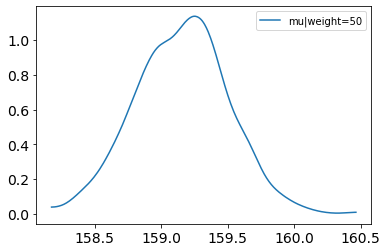

In [ ]:
az.plot_kde(mu_at_50, label="mu|weight=50")
plt.show()

## 4.52

In [ ]:
jnp.percentile(mu_at_50, q=jnp.array([5.5, 94.5]))

DeviceArray([158.5951 , 159.68349], dtype=float32)

## 4.53

In [ ]:
mu = Predictive(m4_3.model, post, return_sites=['mu'])(random.PRNGKey(2), d2.weight.values, None)['mu']
mu[:5, 0]

DeviceArray([156.6727 , 156.53946, 157.60023, 157.05913, 157.28683], dtype=float32)

## 4.54

In [ ]:
weight_seq = jnp.arange(start=25, stop=71, step=1)
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 46), [136.62743, 137.35492, 136.24643, 136.79364, 136.83478])

## 4.55

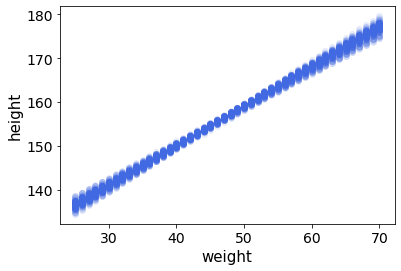

In [ ]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0}
)
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)
plt.show()

## 4.56

In [ ]:
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
mu_mean.shape
mu_PI.shape

(2, 46)

## 4.57

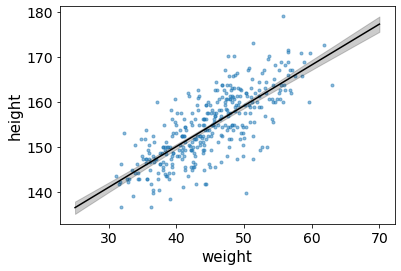

In [ ]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

plt.plot(weight_seq, mu_mean, "k")

plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

## 4.59

In [ ]:
sim_height = Predictive(m4_3.model, post, return_sites=['height'])(random.PRNGKey(2), weight_seq, None)['height']
sim_height.shape, list(sim_height[:5, 0])

((1000, 46), [137.6133, 137.93073, 132.15813, 137.07765, 133.54572])

## 4.60

In [ ]:
sim_height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)
sim_height_PI

DeviceArray([[128.38252, 129.62611, 129.87407, 131.59811, 132.03798,
              132.46106, 133.93329, 134.57225, 135.3258 , 136.21745,
              137.28348, 137.98024, 139.05177, 139.9896 , 140.91757,
              142.11864, 142.62088, 144.30858, 144.66985, 145.17921,
              147.0931 , 147.58185, 148.9809 , 149.2304 , 149.81746,
              150.71576, 152.43814, 152.86224, 153.74165, 155.06142,
              155.59775, 155.79276, 157.0927 , 158.21951, 159.05702,
              159.77411, 160.76367, 161.94727, 162.6288 , 163.31625,
              164.46944, 165.36472, 166.09349, 167.0487 , 168.13051,
              168.7713 ],
             [145.15213, 145.93088, 146.46182, 147.58633, 148.09756,
              149.49197, 150.30508, 150.59213, 151.60867, 152.79524,
              153.65572, 155.17538, 155.29912, 156.16968, 157.78316,
              158.26854, 159.10725, 159.80159, 160.37596, 161.88252,
              163.02101, 163.3662 , 164.13383, 165.49503, 166.32841,
        

## 4.61

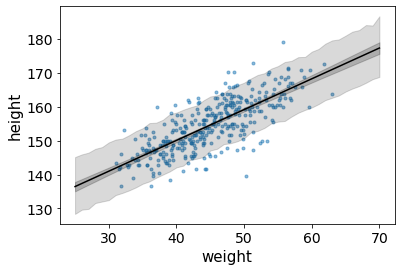

In [ ]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, sim_height_PI[0], sim_height_PI[1], color="k", alpha=0.15)
plt.show()

## 4.62

In [ ]:
post = m4_3.sample_posterior(key, p4_3, (10000,))
sim_height = Predictive(m4_3.model, post, return_sites=['height'])(key, weight_seq, None)['height']
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

## 4.63

In [ ]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
weight_seq = jnp.arange(25, 71)
sim_height = vmap(
    lambda i, weight: dist.Normal(
        post["a"] + post["b"] * (weight - xbar), post["sigma"]
    ).sample(random.PRNGKey(i))
)(jnp.arange(len(weight_seq)), weight_seq).T
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)
jnp.arange(len(weight_seq))

DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
             15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
             30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
             45], dtype=int32)